In [1]:
import pdal

In [12]:
import warnings
warnings.filterwarnings('ignore')
# import geoplot as gplt
# import geoplot.crs as gcrs
import geopandas as gpd
import imageio
import pathlib
import mapclassify as mc
import numpy as np
import laspy
import rasterio
from rasterio import mask
import folium
import matplotlib.pyplot as plt
import logging
import sys
from shapely.geometry import Polygon
sys.path.append("/home/michael/USGS-LIDAR-on-AgriTech")
from fetch_data import FetchData
from script.visualize import Visualize

In [13]:
MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.756055, 42.918115]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))
region = "IA_FullState"

In [16]:
data_fetcher = FetchData(polygon, region)

In [ ]:
data=data_fetcher.run_pipeline()
print(type(data))
df = data_fetcher.get_elevation(data)
print(df.info())
print(df)

In [16]:
## Plot raster/tif image
# --------------------
def plot_raster(rast_data, title=''):
    
    """
    Plots raster tif image both in log scale(+1) and original verion
    """
    fig, (axlog, axorg) = plt.subplots(1, 2, figsize=(14,7))
    im1 = axlog.imshow(np.log1p(rast_data)) # vmin=0, vmax=2.1)
#     im2 = axorg.imshow(rast_data)

    plt.title("{}".format(title), fontdict = {'fontsize': 15})  
    plt.axis('off')
    plt.colorbar(im1, fraction=0.03)

In [17]:
# Read raster/tif file
# --------------------
iowa_tif = '../data/tif/iowa.tif'
raster_iowa = rasterio.open(iowa_tif)
iowa_data = raster_iowa.read(1)

In [18]:
type(iowa_data)

numpy.ndarray

In [19]:
count = iowa_data[iowa_data > 0].sum()
count

623473101.7957066

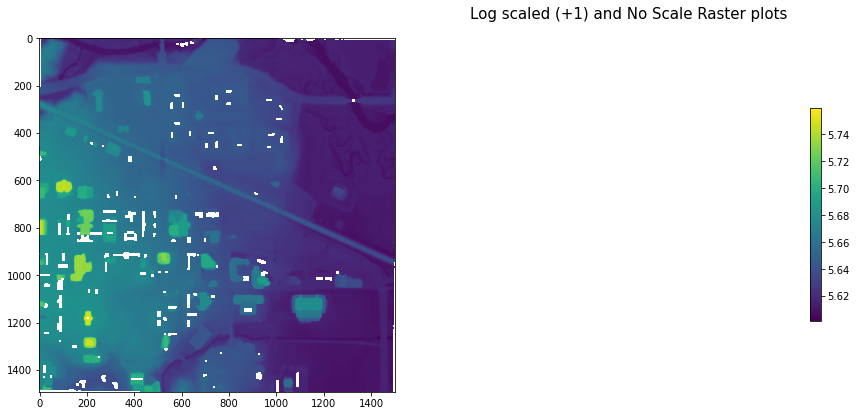

In [20]:
title = 'Log scaled (+1) and No Scale Raster plots'.format(count)
plot_raster(iowa_data, title)

In [21]:
ep.hist(array, title=["Band 1", "Band 2", "Band 3", 'Band 4'])
plt.show()

NameError: name 'ep' is not defined

In [13]:
# get shp from tif
from glob import glob
def get_shp_from_tif(tif_path:str, shp_file_path:str) -> None:
    raster = rasterio.open(tif_path)
    bounds = raster.bounds

    df = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
   
    # save to file
    df.to_file(shp_file_path)
    return df
    print('Saved..')

In [14]:
shp_df = get_shp_from_tif("../data/tif/iowa.tif", "../data/shp")

In [13]:
shp_df

,id,geometry
0,1,"POLYGON ((447611.703 4652575.173, 447611.703 4..."


In [15]:
def select_name(name:str):
    name_ls = []
    names_list =  io.open('../data/filename.txt', encoding='UTF-8').read().strip().split('\n')
    if name in names_list:
        return name
    if name == 'all':
        return names_list
    else:
        for words in names_list:
            words_ls = words.split('_')
            if name in words_ls:
                name_ls.append(words)
            else: continue
        if name_ls == []:
            print(f"Name - ({name}) not found, input a valid name")
            return None
        else: return name_ls

In [18]:
y = select_name('all')

In [4]:
import json

In [5]:
with open('../pipeline.json', 'r')as json_file:
    dict_ob = json.load(json_file)

In [6]:
dict_ob

{'pipeline': [{'bounds': '([-10425171.940, -10423171.940], [5164494.710, 5166494.710])',
   'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json',
   'type': 'readers.ept',
   'tag': 'readdata'},
  {'limits': 'Classification![7:7]',
   'type': 'filters.range',
   'tag': 'nonoise'},
  {'assignment': 'Classification[:]=0',
   'tag': 'wipeclasses',
   'type': 'filters.assign'},
  {'out_srs': 'EPSG:26915',
   'tag': 'reprojectUTM',
   'type': 'filters.reprojection'},
  {'tag': 'groundify', 'type': 'filters.smrf'},
  {'limits': 'Classification[2:2]',
   'type': 'filters.range',
   'tag': 'classify'},
  {'filename': 'data/laz/iowa.laz',
   'inputs': ['classify'],
   'tag': 'writerslas',
   'type': 'writers.las'},
  {'filename': 'data/tif/iowa.tif',
   'gdalopts': 'tiled=yes,     compress=deflate',
   'inputs': ['writerslas'],
   'nodata': -9999,
   'output_type': 'idw',
   'resolution': 1,
   'type': 'writers.gdal',
   'window_size': 6}]}

In [7]:
piplines = pdal.Pipeline(json.dumps(dict_ob))

In [8]:
piplines

In [10]:
piplines.execute()
metadata = piplines.metadata
log = piplines.log

RuntimeError: readers.ept: Error reading tile: Could not read from s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept-data/1-0-1-1.laz